In [1]:
# Import the fabapi module, as well as some other stuff for working with data. 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import viz

from fabapi import *
from tqdm import tqdm
from os import path

colors = viz.color_palette()
cnames_lin = 'green,blue,yellow,purple,red'.split(',')
lin_colors = [colors[c] for c in cnames_lin]

# Load the style file style.mpl
plt.style.use('style.mpl')

In [2]:
print(colors)

{'green': '#7AA974', 'light_green': '#BFD598', 'pale_green': '#DCECCB', 'yellow': '#EAC264', 'light_yellow': '#F3DAA9', 'pale_yellow': '#FFEDCE', 'blue': '#738FC1', 'light_blue': '#A9BFE3', 'pale_blue': '#C9D7EE', 'red': '#D56C55', 'light_red': '#E8B19D', 'pale_red': '#F1D4C9', 'purple': '#AB85AC', 'light_purple': '#D4C2D9', 'dark_green': '#7E9D90', 'dark_brown': '#905426', 'dark_blue': '#535D87'}


In [3]:
summary_df = pd.read_csv('../output/findabug/chemoauto_summary.csv')
cols_of_interest = ['genome_id', 'rubisco_csome', 'rubisco_csome_fdh', 
                    'rubisco_csome_h2ase', 'rubisco_csome_fdh_h2ase']
summary_df = summary_df[cols_of_interest]

rows2keep = summary_df[cols_of_interest[1:]].any(axis=1)
summary_df = summary_df[rows2keep]
print('number of genomes:', summary_df.shape[0])
summary_df.head()

number of genomes: 670


,genome_id,rubisco_csome,rubisco_csome_fdh,rubisco_csome_h2ase,rubisco_csome_fdh_h2ase
9,GCA_000063505.1,True,False,False,False
10,GCA_000063525.1,True,False,False,False
37,GCA_000218705.1,True,False,False,False
38,GCA_000218745.1,True,False,False,False
41,GCA_000227525.2,True,True,False,False


In [4]:
genome_ids = summary_df['genome_id'].values

results = []
# request 50 genomes at a time
for i in tqdm(range(0, len(genome_ids), 50)):
    q = Query('metadata')
    q.equal_to('genome_id', genome_ids[i:i+50])
    results.append(q.get())
result_df = pd.concat(results)

100%|██████████| 14/14 [00:02<00:00,  6.59it/s]


In [5]:
result_df.to_csv('genomes_of_interest_metadata.csv', index=False)

# merge the gtdb taxonomic cols in summary_df
tax_cols = ['genome_id', 'gtdb_domain', 'gtdb_phylum', 'gtdb_class', 'gtdb_order', 'gtdb_family', 'gtdb_genus', 'gtdb_species']
summary_annot_df = pd.merge(summary_df, result_df[tax_cols], on='genome_id')
summary_annot_df.genome_id.unique().size

670

In [6]:
order_counts = summary_annot_df.groupby('gtdb_order').size().sort_values(ascending=False)
my_orders = order_counts.head(10).index
for_plotting = summary_annot_df[summary_annot_df.gtdb_order.isin(my_orders)]
for_plotting.head()

,genome_id,rubisco_csome,rubisco_csome_fdh,rubisco_csome_h2ase,rubisco_csome_fdh_h2ase,gtdb_domain,gtdb_phylum,gtdb_class,gtdb_order,gtdb_family,gtdb_genus,gtdb_species
0,GCA_000063505.1,True,False,False,False,Bacteria,Cyanobacteria,Cyanobacteriia,PCC-6307,NaN,Synechococcus_C,Synechococcus_C sp000063505
1,GCA_000063525.1,True,False,False,False,Bacteria,Cyanobacteria,Cyanobacteriia,PCC-6307,NaN,RCC307,RCC307 sp000063525
2,GCA_000218705.1,True,False,False,False,Bacteria,Cyanobacteria,Cyanobacteriia,PCC-6307,NaN,Prochlorococcus_A,Prochlorococcus_A marinus_Q
3,GCA_000218745.1,True,False,False,False,Bacteria,Cyanobacteria,Cyanobacteriia,PCC-6307,NaN,Prochlorococcus_A,Prochlorococcus_A marinus_T
5,GCA_000634115.1,True,False,False,False,Bacteria,Cyanobacteria,Cyanobacteriia,PCC-6307,NaN,Prochlorococcus_A,Prochlorococcus_A sp000634115


In [7]:
cols = ['rubisco_csome_fdh', 'rubisco_csome_h2ase', 'rubisco_csome_fdh_h2ase']
ct = pd.crosstab(for_plotting['gtdb_order'], [for_plotting[c] for c in cols],
                 rownames=['gtdb_order'],
                 colnames=cols)
ct_vals = ct.values[:,1:]
sums = ct_vals.sum(axis=1)

# reorder by sums, neglecting rubisco_csome alone
order = np.argsort(sums)[::-1]
ct = ct.iloc[order]
ct


rubisco_csome_fdh       False       True       
rubisco_csome_h2ase     False True  False True 
rubisco_csome_fdh_h2ase False False False True 
gtdb_order                                     
Burkholderiales            19    28    12    13
Chromatiales                0    44     0     6
PCC-6307                  322    46     0     0
Ectothiorhodospirales      19     9     1     8
Thiotrichales               1     7     2     1
Acidithiobacillales         5     6     0     0
Thiomicrospirales          31     4     0     0
Rhizobiales                 4     1     1     2
Acidimicrobiales            2     0     3     0
Halothiobacillales          8     0     1     0

['Burkholderiales' 'Chromatiales' 'Cyanobiaceae' 'Ectothiorhodospirales'
 'Thiotrichales' 'Acidithiobacillales' 'Thiomicrospirales' 'Rhizobiales'
 'Acidimicrobiales' 'Halothiobacillales']


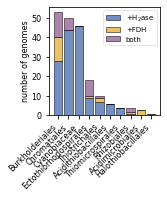

In [9]:
plt.figure(figsize=(2, 2))

# stacked bar values are along the rows below
bar_vals = ct.values[:, 1:]

# plot the stacked bar chart
xs = np.arange(len(ct.index))
plt.bar(xs, bar_vals[:, 0], color=lin_colors[1], edgecolor='k', lw=0.5)
plt.bar(xs, bar_vals[:, 1], bottom=bar_vals[:, 0], color=lin_colors[2], edgecolor='k', lw=0.5)
plt.bar(xs, bar_vals[:, 2], bottom=bar_vals[:, 0]+bar_vals[:, 1], color=lin_colors[3], edgecolor='k', lw=0.5)


# relabel legend
plt.legend(['+H$_2$ase', '+FDH', 'both'], loc=1, framealpha=0.5)

my_xticks = ct.index.values
print(my_xticks)
# find PCC-6307, replace with its only family Cyanobiaceae
my_xticks[my_xticks == 'PCC-6307'] = 'Cyanobiaceae'

tick_pos = np.arange(0, len(my_xticks), 1)
plt.xticks(tick_pos, my_xticks, rotation=45, ha='right')
plt.ylabel('number of genomes')
plt.xlabel('')
plt.savefig('../output/plots/top_hits_by_order.pdf', bbox_inches='tight')
plt.savefig('../output/plots/top_hits_by_order.png', bbox_inches='tight')

plt.show()


array([145,  20,  30])